In [2]:
import pybinding as pb
import numpy as np
import matplotlib.pyplot as plt

pb.pltutils.use_style()
%matplotlib inline

# Band structure

In order to calculate the band structure of a crystal lattice, this section introduces the concepts of a [`Model`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.Model.html#pybinding.Model) and a [`Solver`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.solver.html#pybinding.solver.Solver).

[Download this page as a Jupyter notebook](http://docs.pybinding.site/page/_downloads/bands.ipynb)

## Model

A [`Model`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.Model.html#pybinding.Model) contains the full tight-binding description of the physical system that we wish to solve. We'll start by assigning a lattice to the model, and we'll use a pre-made one from the material repository.

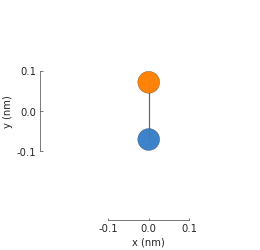

In [3]:
from pybinding.repository import graphene

model = pb.Model(graphene.monolayer())
model.plot()

The result is not very exciting: just a single graphene unit cell with 2 atoms and a single hopping between them. The model does not assume translational symmetry or any other physical property. Given a lattice, it will just create a single unit cell. The model has a [`System`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.system.html#pybinding.system.System) attribute which keeps track of structural properties like the positions of lattice sites and the way they are connected, as seen in the figure above. The raw data can be accessed directly:

In [4]:
model.system.x

array([ 0.,  0.], dtype=float32)

In [5]:
model.system.y

array([-0.071,  0.071], dtype=float32)

In [6]:
model.system.sublattices

AliasArray([0, 1], dtype=int32)

Each attribute is a 1D array where the number of elements is equal to the total number of lattice sites in the system. The model also has a [`hamiltonian`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.Model.html#pybinding.Model.hamiltonian) attribute:

In [7]:
model.hamiltonian

<2x2 sparse matrix of type '<class 'numpy.float32'>'
	with 2 stored elements in Compressed Sparse Row format>

It's a sparse matrix (see [`scipy.sparse.csr_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix)) which corresponds to the tight-binding Hamiltonian of our model. The output above shows the default sparse representation of the data where each line corresponds to `(row, col) value`. Alternatively, we can see the dense matrix output:

In [8]:
model.hamiltonian.todense()

matrix([[ 0.        , -2.79999995],
        [-2.79999995,  0.        ]], dtype=float32)

Next, we include [`translational_symmetry()`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.translational_symmetry.html#pybinding.translational_symmetry) to create an infinite graphene sheet.

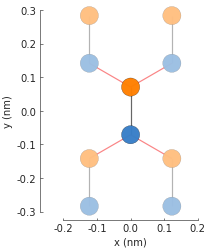

In [9]:
model = pb.Model(
    graphene.monolayer(),
    pb.translational_symmetry()
)
model.plot()

The red lines indicate hoppings on periodic boundaries. The lighter colored circles represent the translations of the unit cell. The number of translations is infinite, but the plot only presents the first one in each lattice vector direction.

## Solver

A [`Solver`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.solver.html#pybinding.solver.Solver) can exactly calculate the eigenvalues and eigenvectors of a Hamiltonian matrix. We'll take a look at various [Eigenvalue solvers](http://docs.pybinding.site/page/tutorial/solvers.html) and their capabilities in a later section, but right now we'll just grab the [`lapack()`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.solver.html#pybinding.solver.lapack) solver which is the simplest and most appropriate for small systems.

In [10]:
model = pb.Model(graphene.monolayer())
solver = pb.solver.lapack(model)
solver.eigenvalues

array([-2.79999995,  2.79999995], dtype=float32)

In [11]:
solver.eigenvectors

array([[-0.70710677, -0.70710677],
       [-0.70710677,  0.70710677]], dtype=float32)

Beyond just the [`eigenvalues`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.solver.html#pybinding.solver.Solver.eigenvalues) and [`eigenvectors`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.solver.html#pybinding.solver.Solver.eigenvectors) properties, [`Solver`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.solver.html#pybinding.solver.Solver) has a convenient [`calc_bands()`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.solver.html#pybinding.solver.Solver.calc_bands) method which can be used to calculate the band structure of our model.

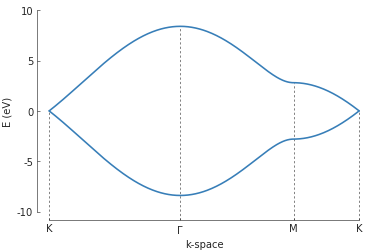

In [12]:
from math import sqrt, pi

model = pb.Model(graphene.monolayer(), pb.translational_symmetry())
solver = pb.solver.lapack(model)

a_cc = graphene.a_cc
Gamma = [0, 0]
K1 = [-4*pi / (3*sqrt(3)*a_cc), 0]
M = [0, 2*pi / (3*a_cc)]
K2 = [2*pi / (3*sqrt(3)*a_cc), 2*pi / (3*a_cc)]

bands = solver.calc_bands(K1, Gamma, M, K2)
bands.plot(point_labels=['K', r'$\Gamma$', 'M', 'K'])

The points $\Gamma, K$ and $M$ are used to draw a path in the reciprocal space of graphene's Brillouin zone and [`Solver.calc_bands()`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.solver.html#pybinding.solver.Solver.calc_bands) calculates the band energy along that path. The return value of the method is a [`Bands`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.Bands.html#pybinding.Bands) result object.

All result objects have built-in plotting methods. Aside from the basic [`plot()`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.Bands.html#pybinding.Bands.plot) seen above, [`Bands`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.Bands.html#pybinding.Bands) also has [`plot_kpath()`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.Bands.html#pybinding.Bands.plot_kpath) which presents the path in reciprocal space. Plots can easily be composed, so to see the path in the context of the Brillouin zone, we can simply plot both:

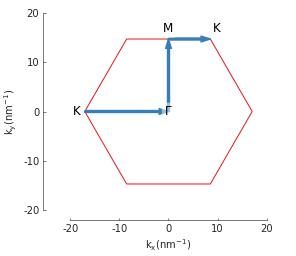

In [13]:
model.lattice.plot_brillouin_zone(decorate=False)
bands.plot_kpath(point_labels=['K', r'$\Gamma$', 'M', 'K'])

The extra argument for [`Lattice.plot_brillouin_zone()`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.Lattice.html#pybinding.Lattice.plot_brillouin_zone) turns off the reciprocal lattice vectors and vertex coordinate labels (as seen in the previous section).

> The band structure along a path in k-space can also be calculated manually by saving an array of [`Solver.eigenvalues`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.solver.html#pybinding.solver.Solver.eigenvalues) at different k-points. This process is shown on the [Eigensolver](http://docs.pybinding.site/page/tutorial/solvers.html#manual-band-calculation) page.

## Switching lattices

We can easily switch to a different material, just by passing a different lattice to the model. For this example, we'll use our pre-made `graphene.bilayer()` from the [Material Repository](http://docs.pybinding.site/page/tutorial/../materials/index.html). But you can create any lattice as described in the previous section: [Lattice](http://docs.pybinding.site/page/tutorial/lattice.html).

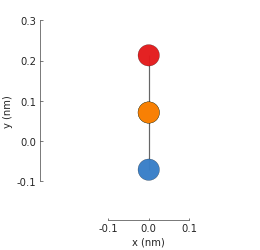

In [14]:
model = pb.Model(graphene.bilayer())
model.plot()

Without [`translational_symmetry()`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.translational_symmetry.html#pybinding.translational_symmetry), the model is just a single unit cell with 4 atoms. Our bilayer lattice uses AB-stacking where a pair of atoms are positioned one on top of the another. By default, the [`Model.plot()`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.Model.html#pybinding.Model.plot) method shows the xy-plane, so one of the bottom atoms isn't visible. We can pass an additional plot argument to see the yz-plane:

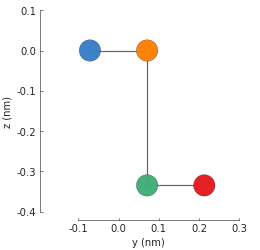

In [15]:
model = pb.Model(graphene.bilayer())
model.plot(axes='yz')

To compute the band structure, we'll need to include [`translational_symmetry()`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.translational_symmetry.html#pybinding.translational_symmetry).

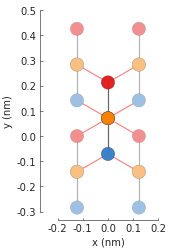

In [16]:
model = pb.Model(graphene.bilayer(), pb.translational_symmetry())
model.plot()

As before, the red hoppings indicate periodic boundaries and the lighter colored circles represent the first of an infinite number of translation units. We'll compute the band structure for the same $\Gamma$, $K$ and $M$ points as monolayer graphene:

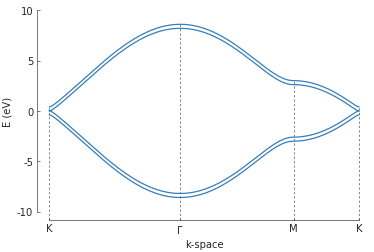

In [17]:
solver = pb.solver.lapack(model)
bands = solver.calc_bands(K1, Gamma, M, K2)
bands.plot(point_labels=['K', r'$\Gamma$', 'M', 'K'])

## Further reading

Check out the [examples section](http://docs.pybinding.site/page/tutorial/../examples/lattice/index.html) for more band structure calculations with various other lattices. [Eigenvalue solvers](http://docs.pybinding.site/page/tutorial/solvers.html) will be covered in more detail at a later point in the tutorial, but this is enough information to get started. The next few sections are going to be dedicated to model building.

## Example

[Download source code](http://docs.pybinding.site/page/_downloads/bands_example.py)

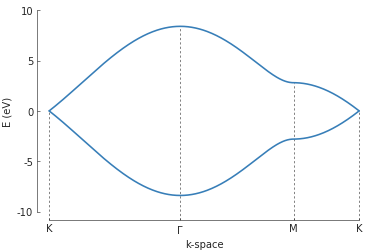

In [18]:
"""Calculate and plot the band structure of monolayer graphene"""
import pybinding as pb
import matplotlib.pyplot as plt
from math import sqrt, pi
from pybinding.repository import graphene

pb.pltutils.use_style()


model = pb.Model(
    graphene.monolayer(),  # predefined lattice from the material repository
    pb.translational_symmetry()    # creates an infinite sheet of graphene
)
solver = pb.solver.lapack(model)  # eigensolver from the LAPACK library

# significant points in graphene's Brillouin zone
a_cc = graphene.a_cc  # carbon-carbon distance
Gamma = [0, 0]
K1 = [-4*pi / (3*sqrt(3)*a_cc), 0]
M = [0, 2*pi / (3*a_cc)]
K2 = [2*pi / (3*sqrt(3)*a_cc), 2*pi / (3*a_cc)]

# plot the bands through the desired points
bands = solver.calc_bands(K1, Gamma, M, K2)
bands.plot(point_labels=['K', r'$\Gamma$', 'M', 'K'])
plt.show()